<a href="https://colab.research.google.com/github/kg4-ken1ro/mypandas_tutorial_3/blob/main/study_tutorial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pylab as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

In [ ]:
def validate(train_x, train_y):
  accuracies = []
  feature_importances = []

  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
  for train_idx, test_idx in cv.split(train_x, train_y):
    trn_x =train_x.iloc[train_idx, :]
    val_x = train_x.iloc[test_idx, :]

    trn_y = train_y.iloc[train_idx]
    val_y = train_y.iloc[test_idx]

    clf = xgb.XGBClassifier()
    clf.fit(trn_x, trn_y)

    pred_y = clf.predict(val_x)
    feature_importances.append(clf.feature_importances_)
    accuracies.append(accuracy_score(val_y, pred_y))
  print(np.mean(accuracies))
  return accuracies, feature_importances

In [ ]:
def plot_feature_importances(feature_importances, cols):
  df_fimp = pd.DataFrame(feature_importances, columns=cols)
  df_fimp.plot(kind="box", rot=90)

In [ ]:
def preprocess_df(df):
  #CabinはこのあとDropするので、コードから削除
  df["Age"] = df["Age"].fillna(df["Age"].mean())
  df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
  #FamilySize列を作成
  df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

  #列の削除
  df.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)

  #Sexを0と1に置換とEmbarkedのダミー化
  df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})
  df = pd.get_dummies(df)

  #Parch, SibSpが0の人、FamilySizeが１の場合Flagを立てる
  #[1 if val == 0 else 0 for val in df[列名]]の部分はリスト内包表記
  df["None_Parch"] = [1 if val == 0 else 0 for val in df["Parch"]]
  df["None_SibSp"] = [1 if val == 0 else 0 for val in df["SibSp"]]
  df["None_Family"] = [1 if val == 1 else 0 for val in df["FamilySize"]]

  #0-10歳は生存者が多いかも
  df["Flag_Children"] = [1 if val < 11 else 0 for val in df["Age"]]
  
  return df

In [ ]:
#testデータのpredict
def predict_df(train_x, train_y, test_x, df_test_raw,path_output="result.csv"):
  clf = xgb.XGBClassifier()
  clf.fit(train_x, train_y)
  preds = clf.predict(test_x)

  _df = pd.DataFrame()
  _df["PassengerId"] = df_test_raw["PassengerId"]
  _df["Survived"] = preds
  _df.to_csv(path_output, index=False)

0.8058361391694726


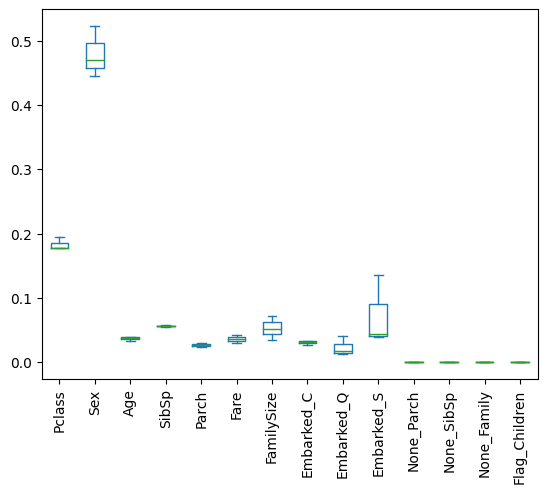

In [ ]:
#デバッグするときはmain関数から外して、直接叩く方が楽
def main():
  df_train = pd.read_csv("drive/My Drive/train.csv")

  #前処理
  train_y = df_train["Survived"]
  train_x = df_train.drop("Survived", axis=1)
  
  train_x = preprocess_df(train_x)
  accuracies, feature_importances = validate(train_x, train_y)
  plot_feature_importances(feature_importances, train_x.columns)

  flag_product = True
  if flag_product:
    df_test = pd.read_csv("drive/My Drive/test.csv")#colabの場合、driveをマウントするのを忘れない
    df_test_raw = df_test.copy()
    test_x = preprocess_df(df_test)
    predict_df(train_x, train_y, test_x, df_test_raw, "result.csv")

#`if __name__ == '__main__':` はおまじないのようなモノと思ってください。
if __name__ == '__main__':
  main()